## <center> **Анализ результатов A/B-тестирования**

Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта компании и провела A/B-тестирование. Собранные в результате проведения эксперимента данные вы можете найти здесь.

Вам предстоит решить настоящую бизнес-задачу: проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям: конверсии покупки и среднему чеку. На основе проведенного анализа вам будет необходимо сделать выводы и принять решение: какой из вариантов дизайна более предпочтительный.

Итак, наша фирма предлагает следующие варианты туров и их соответствующие стоимости:
* Таиланд — 100000 рублей;
* Турция — 60000 рублей;
* Мальдивы — 200000 рублей;
* Санкт-Петербург — 10000 рублей;
* Камчатка — 150000 рублей.

In [118]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_ind, shapiro, f_oneway, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest

Прочитаем наши данные и посмотрим на столбцы таблицы:

In [119]:
data = pd.read_csv('ab_data_tourist.csv')
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


 ### Назначение полей таблицы

|Название поля|Описание|
|--------------|---------|
|user_id|идентификатор пользователя, зашедшего на сайт|
|date|дата захода|
|group|группа теста (контрольная — А или тестовая — B)|
|purchase|признак покупки: совершил ли пользователь покупку тура (1 — да, 0 — нет)|
|price| цена купленного тура (если покупка не состоялась, цена равна 0)|

## **Задание 7.1.**

Начнем с исследования структуры наших данных. С помощью метода info() выведите информацию о типах данных и количестве непустых значений. Какой тип данных имеет столбец date?

In [120]:
# ваш код здесь
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


## **Задание 7.2.**

Приведите столбец date к типу данных datetime. Убедитесь в равной длительности проведения тестирования для каждой из группы. Для этого сгруппируйте данные по признаку группы и определите первую и последнюю дату наблюдения для каждой из групп. 

В какой промежуток времени проводился A/B-тест?


In [121]:
# ваш код здесь
data.date = pd.to_datetime(data.date)

In [122]:
data.groupby('group')['date'].agg({'min', 'max'})

,min,max
group,,
A,2021-01-02,2021-01-24
B,2021-01-02,2021-01-24


## **Задание 7.3.**

* Чему равно количество посещений сайта в группах А и B?

* Чему равно суммарное количество покупок в группах А и B?

* Чему равна сумма всех покупок в группах А и B?

Ответ приведите в миллионах рублей. Например, 185.52 млн. руб.

In [123]:
# ваш код здесь
data_gr_by_ab = data.groupby('group')[['user_id', 'purchase', 'price']].agg({
    'user_id': 'count',
    'purchase': 'sum',
    'price': 'sum'
})

n_a = data_gr_by_ab.loc['A', 'user_id']
n_b = data_gr_by_ab.loc['B', 'user_id']
print(f'Количество посещений сайта в группе A: {n_a}')
print(f'Количество посещений сайта в группе B: {n_b}')

purch_cnt_a = data_gr_by_ab.loc['A', 'purchase']
purch_cnt_b = data_gr_by_ab.loc['B', 'purchase']
print(f'Количество покупок в группе A: {purch_cnt_a}')
print(f'Количество покупок в группе B: {purch_cnt_b}')


sum_a = data_gr_by_ab.loc['A', 'price']
sum_b = data_gr_by_ab.loc['B', 'price']
print(f'Сумма продаж в группе A: {sum_a / 1e6} млн')
print(f'Сумма продаж в группе B: {sum_b / 1e6} млн')

Количество посещений сайта в группе A: 147202
Количество посещений сайта в группе B: 147276
Количество покупок в группе A: 17723
Количество покупок в группе B: 17514
Сумма продаж в группе A: 1436.26 млн
Сумма продаж в группе B: 1554.1 млн


## **Задание 7.4.**

Проверьте, есть ли пользователи, которые в процессе A/B-теста попали в обе тестовые группы? Если да, то сколько таких уникальных пользователей, если нет - введите в поле для ответа 0?

**Подсказка:**

*Создайте множество пользователей группы А и множество пользователей группы B. Пересеките два этих множества (операция intersection) и вычислите количество элементов в полученном множестве.*


In [124]:
# ваш код здесь
users_a = set(data[data.group == 'A'].user_id.unique())
users_b = set(data[data.group == 'B'].user_id.unique())
users_ab = set.intersection(users_a, users_b)
len(users_ab)

1895

## **Исключите пользователей, оказавшихся в обеих группах**

Так как мы не можем определить, какая из версий сайта повлияла на принятие решения, исключим этих пользователей. Далее мы будем работать только с очищенными от пересечений данными.

Возможный вариант исключения пользователей:

In [125]:
updated_data = data[data['user_id'].apply(lambda x: x not in users_ab)]

Где users_ab - множество пересечений пользователей групп А и B.

## **Задание 7.5.**

Для первичного анализа результатов A/B-тестирования нам понадобится таблица следующего вида:

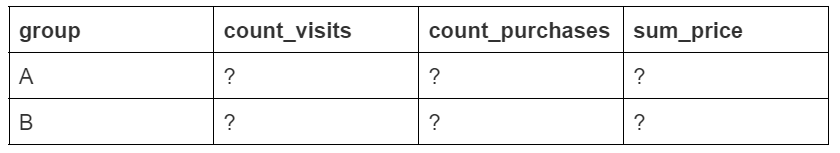
 
 
Для того, чтобы получить такую таблицу, сгруппируйте данные по признаку группы. В каждой группе рассчитайте следующие показатели:
* количество посещений (количество пользователей)
* количество совершенных покупок
* сумма всех покупок в группе

В полученной сгруппированной таблице переименуйте столбцы на **count_visits, count_purchases и sum_price**.

**Подсказка:**

*Для переименования столбцов можно использовать метод rename() с параметром columns, в который передается словарь. Ключи этого словаря - старые имена столбцов, а значения - новые.*

Чему на этот раз равно количество посещений сайта в группах А и B?


In [126]:
# ваш код здесь
data_gr_by_ab = updated_data.groupby('group')[['user_id', 'purchase', 'price']].agg({
    'user_id': 'count',
    'purchase': 'sum',
    'price': 'sum'
})

data_gr_by_ab.reset_index(drop=False, inplace=True)
data_gr_by_ab.columns = ['group', 'count_visits', 'count_purchases', 'sum_price']
data_gr_by_ab

,group,count_visits,count_purchases,sum_price
0,A,145307,17487,1417780000
1,B,145381,17290,1533010000


Приведите промежуточные выводы по построенной таблице. Сопоставимо ли количество посещений обоих вариантов посадочной странице, можно ли говорить о сбалансированности выборок?

Промежуточные выводы:
1. Были пользователи присутствущие в обеих группах. Избавились от записей по ним;
2. Даже после этого количество наблюдений по каждой группе примерно одинаково;
3. Видим, что сумма продаж в группе B больше. Потребуется протестировать гипотезу о равенстве средних чеков в группах с альтернативной гипотезой о том, что средний чек в группе A меньше, чем в группе B.

## **Задание 7.6.**

Добавьте в сгруппированную таблицу столбцы conversion - конверсия покупки (отношение количества покупок к количеству посещений сайта в каждой группе, выраженное в процентах) и mean_check - средний чек (отношение суммы покупок к количеству покупок в каждой группе).

* Чему равна конверсия в группах? Ответ приведите в процентах и округлите до сотых. Например, 75.12 %
* Чему равен средний чек в группах? Ответ приведите в рублях и округлите до целых. Например, 120519 рублей.

In [127]:
# ваш код здесь
data_gr_by_ab['conversion'] = round(100 * data_gr_by_ab.count_purchases / data_gr_by_ab.count_visits, 2)
data_gr_by_ab['mean_check'] = round(data_gr_by_ab.sum_price / data_gr_by_ab.count_purchases)
data_gr_by_ab

,group,count_visits,count_purchases,sum_price,conversion,mean_check
0,A,145307,17487,1417780000,12.03,81076.0
1,B,145381,17290,1533010000,11.89,88665.0


Приведите промежуточные выводы по таблице. По какому(им) показателю(ям) вариант А эффективнее варианта B и наоборот?

Промежуточные выводы:
1. Потребуется протестировать гипотезу о равенстве конверсий в групппах A и B с альтернативной гипотезой о том, что конверсия в группе A выше, чем в группе B;
2. Видим, что средний чек в группе B больше. Потребуется протестировать гипотезу о равенстве средних чеков в группах с альтернативной гипотезой о том, что средний чек в группе A меньше, чем в группе B.

## **Задание 7.7.**

Теперь давайте сравним варианты по покупательской способности туров. Для этого постройте сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура. 

In [128]:
# ваш код здесь
report = updated_data[updated_data['price'] != 0].groupby(['group', 'price'])['purchase'].count().reset_index(drop=False)
report.columns = ['group', 'price', 'purchases_count']
report

,group,price,purchases_count
0,A,10000,5182
1,A,60000,5271
2,A,100000,1832
3,A,150000,3478
4,A,200000,1724
5,B,10000,5201
6,B,60000,1730
7,B,100000,5227
8,B,150000,3438
9,B,200000,1694


In [129]:
report_pivot = pd.pivot_table(report, values='purchases_count', index='group', columns=['price'])
report_pivot

price,10000,60000,100000,150000,200000
group,,,,,
A,5182,5271,1832,3478,1724
B,5201,1730,5227,3438,1694


Визуализируйте полученную сводную таблицу с помощью тепловой карты с аннотацией. 
Чему равно количество проданных туров за 60000 рублей в группах?

Text(0.5, 1.0, 'Тепловая карта количества продаж туров в зависимости от группы и стоимости тура')

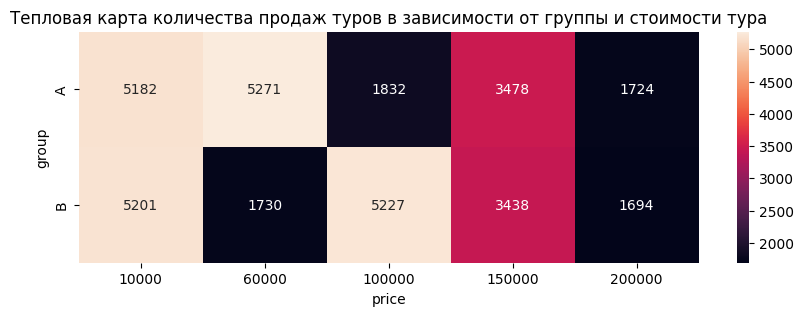

In [130]:
# ваш код здесь
plt.figure(figsize=(10, 3))
sns.heatmap(report_pivot, annot=True, fmt='.0f')
plt.title('Тепловая карта количества продаж туров в зависимости от группы и стоимости тура')

Сделайте выводы по построенной таблице. По каким турам покупательская способность участников группы А выше, чем участников группы B и наоборот?

Предварительные выводы:
1. Не наблюдается большая разность в количестве продаж туров стоимостью 10 т.р. меджу группами A и B;
2. Наблюдается приобладание количества продаж туров за 60 т.р. в группе А;
3. Наблюдается приобладание количества продаж туров за 100 т.р. в группе B;
4. Не наблюдается большая разность в количестве продаж туров стоимостью 150 т.р. меджу группами A и B;
5. Не наблюдается большая разность в количестве продаж туров стоимостью 200 т.р. меджу группами A и B;

## **Задание 7.8.**

Настало время поговорить о стабилизации кумулятивных метрик во времени. Но прежде, чем перейти к кумулятивным метрикам, нам необходимо построить таблицу с ежедневными данными результатов проведения A/B-тестирования.

Сгруппируйте данные по дате и группе тестирования. В каждой группе вычислите количество посещений страницы, количество покупок и сумму покупок. 

Добавьте в таблицу информацию о ежедневной конверсии (ежедневное количество покупок / ежедневное количество посещений) в группе и ежедневном среднем чеке (ежедневная сумма покупок / ежедневное количество покупок)
* Чему равна конверсия 3 января 2021 года? Ответ приведите в процентах и округлите до сотых.

* Чему равен средний чек 3 января 2021 года? Ответ приведите в рублях и округлите до целого.

In [131]:
# ваш код здесь
daily_visits_sales = updated_data.groupby(['date', 'group'])[['user_id', 'purchase', 'price']].agg(
    {
        'user_id': 'count',
        'purchase': 'sum',
        'price': 'sum'
    }
)

daily_visits_sales.columns = ['visits_cnt', 'purchases_cnt', 'sales_sum']
daily_visits_sales['conversion'] = round(100 * daily_visits_sales.purchases_cnt / daily_visits_sales.visits_cnt, 2)
daily_visits_sales['mean_check'] = round(daily_visits_sales.sales_sum / daily_visits_sales.purchases_cnt)
daily_visits_sales.mean_check = daily_visits_sales.mean_check.astype('int')
daily_visits_sales

visits_cnt  purchases_cnt  sales_sum  conversion  mean_check
date       group                                                              
2021-01-02 A            2854            359   29410000       12.58       81922
           B            2861            345   29660000       12.06       85971
2021-01-03 A            6596            748   62000000       11.34       82888
           B            6619            754   65960000       11.39       87480
2021-01-04 A            6566            799   64250000       12.17       80413
           B            6536            764   68030000       11.69       89045
2021-01-05 A            6433            790   64550000       12.28       81709
           B            6511            749   63550000       11.50       84846
2021-01-06 A            6606            764   63410000       11.57       82997
           B            6751            838   75020000       12.41       89523
2021-01-07 A            6579            795   67290000       12.08       84642
           B            6616            767   67170000       11.59       87575
2021-01-08 A            6687            798   65380000       11.93       81930
           B            6714            812   71270000       12.09       87771
2021-01-09 A            6633            794   65610000       11.97       82632
           B            6628            784   71410000       11.83       91084
2021-01-10 A            6659            759   58950000       11.40       77668
           B            6701            846   78080000       12.62       92293
2021-01-11 A            6699            797   58760000       11.90       73726
           B            6679            770   66960000       11.53       86961
2021-01-12 A            6540            795   68460000       12.16       86113
           B            6635            807   70560000       12.16       87435
2021-01-13 A            6564            764   63590000       11.64       83233
           B            6495            720   65910000       11.09       91542
2021-01-14 A            6543            825   65890000       12.61       79867
           B            6608            792   68990000       11.99       87109
2021-01-15 A            6701            806   67570000       12.03       83834
           B            6563            747   69160000       11.38       92584
2021-01-16 A            6601            808   66210000       12.24       81943
           B            6544            786   70560000       12.01       89771
2021-01-17 A            6619            809   63020000       12.22       77899
           B            6546            831   75300000       12.69       90614
2021-01-18 A            6511            812   62850000       12.47       77401
           B            6603            822   72240000       12.45       87883
2021-01-19 A            6582            790   63680000       12.00       80608
           B            6562            772   67820000       11.76       87850
2021-01-20 A            6533            749   58710000       11.46       78385
           B            6685            790   69250000       11.82       87658
2021-01-21 A            6750            851   70300000       12.61       82609
           B            6555            760   69870000       11.59       91934
2021-01-22 A            6587            788   63690000       11.96       80825
           B            6659            787   68660000       11.82       87243
2021-01-23 A            6698            843   70950000       12.59       84164
           B            6633            805   68930000       12.14       85627
2021-01-24 A            3766            444   33250000       11.79       74887
           B            3677            442   38650000       12.02       87443

## **Задание 7.9.** 

Добавьте в таблицу с ежедневными показателями кумулятивные признаки:
* кумулятивное количество посещений страницы
* кумулятивное количество покупок
* кумулятивную сумму покупок

Не забудьте при расчете кумулятивной суммы сгруппировать данные по группам. 

Вычислите кумулятивную конверсию и кумулятивный средний чек на основе полученных кумулятивных показателей. 

* Какая **кумулятивная** конверсия была в группе B на 20 января? Ответ приведите в процентах, округлив до сотых.
* Какой **кумулятивный** средний чек был в группе А на 12 января 2021 года? Ответ приведите в рублях, округлив до целых.

In [132]:
# ваш код здесь
daily_visits_sales.reset_index(drop=False, inplace=True)
daily_visits_sales['cum_visits_cnt'] = daily_visits_sales.groupby('group')['visits_cnt'].cumsum()
daily_visits_sales['cum_purchases_cnt'] = daily_visits_sales.groupby('group')['purchases_cnt'].cumsum()
daily_visits_sales['cum_sales_sum'] = daily_visits_sales.groupby('group')['sales_sum'].cumsum()
daily_visits_sales.head(6)

,date,group,visits_cnt,purchases_cnt,sales_sum,conversion,mean_check,cum_visits_cnt,cum_purchases_cnt,cum_sales_sum
0,2021-01-02,A,2854,359,29410000,12.58,81922,2854,359,29410000
1,2021-01-02,B,2861,345,29660000,12.06,85971,2861,345,29660000
2,2021-01-03,A,6596,748,62000000,11.34,82888,9450,1107,91410000
3,2021-01-03,B,6619,754,65960000,11.39,87480,9480,1099,95620000
4,2021-01-04,A,6566,799,64250000,12.17,80413,16016,1906,155660000
5,2021-01-04,B,6536,764,68030000,11.69,89045,16016,1863,163650000


In [136]:
daily_visits_sales['cum_conversion'] = round(100 * daily_visits_sales.cum_purchases_cnt / daily_visits_sales.cum_visits_cnt, 2)
daily_visits_sales['cum_mean_check'] = round(daily_visits_sales.cum_sales_sum / daily_visits_sales.cum_purchases_cnt)
daily_visits_sales

,date,group,visits_cnt,purchases_cnt,sales_sum,conversion,mean_check,cum_visits_cnt,cum_purchases_cnt,cum_sales_sum,cum_conversion,cum_mean_check
0,2021-01-02,A,2854,359,29410000,12.58,81922,2854,359,29410000,12.58,81922.0
1,2021-01-02,B,2861,345,29660000,12.06,85971,2861,345,29660000,12.06,85971.0
2,2021-01-03,A,6596,748,62000000,11.34,82888,9450,1107,91410000,11.71,82575.0
3,2021-01-03,B,6619,754,65960000,11.39,87480,9480,1099,95620000,11.59,87006.0
4,2021-01-04,A,6566,799,64250000,12.17,80413,16016,1906,155660000,11.90,81668.0
5,2021-01-04,B,6536,764,68030000,11.69,89045,16016,1863,163650000,11.63,87842.0
6,2021-01-05,A,6433,790,64550000,12.28,81709,22449,2696,220210000,12.01,81680.0
7,2021-01-05,B,6511,749,63550000,11.50,84846,22527,2612,227200000,11.59,86983.0
8,2021-01-06,A,6606,764,63410000,11.57,82997,29055,3460,283620000,11.91,81971.0
9,2021-01-06,B,6751,838,75020000,12.41,89523,29278,3450,302220000,11.78,87600.0


Постройте кумулятивные графики конверсии и среднего чека в каждой группе по дням. Сделайте выводы. Можно ли назвать A/B-тест завершенным - стабилизировались ли значения метрик во времени? Как соотносятся кумулятивные показатели в каждой группе?

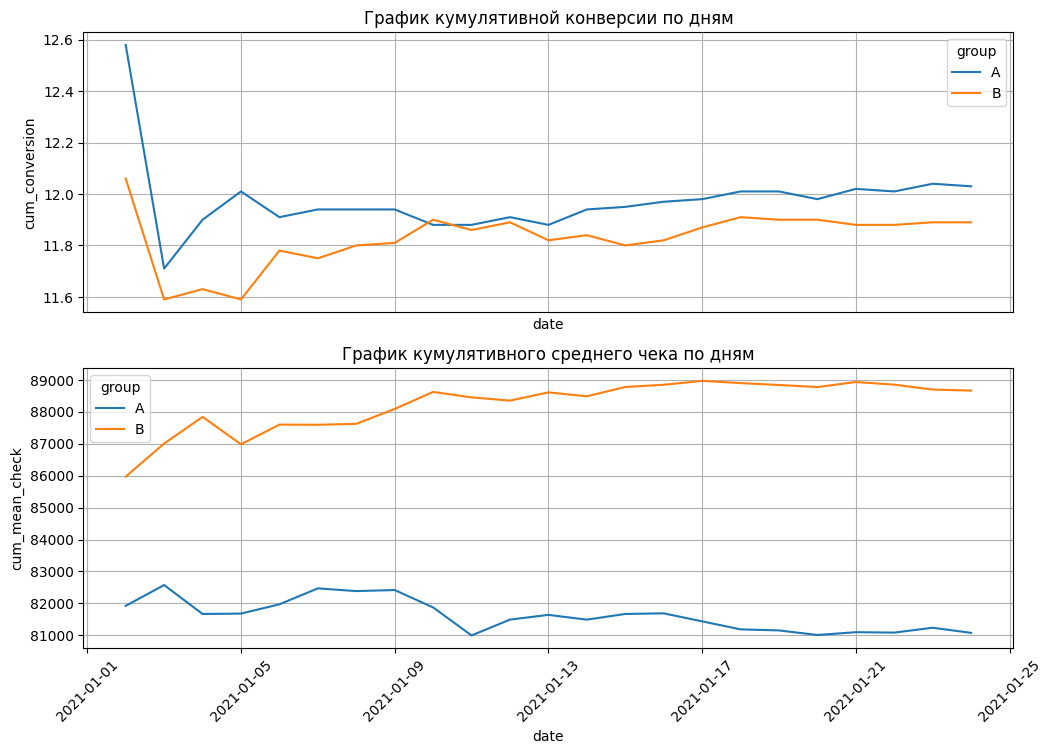

In [143]:
# ваш код здесь
# создаём фигуру размером 8x4
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

# добавляем систему координат
# for axis in ax:
#     axis = fig.add_axes([1, 1, 1, 1])

# строим lineplot для кумулятивной конверсии во времени в каждой группе
sns.lineplot(
    data=daily_visits_sales,
    x='date',
    y='cum_conversion',
    hue='group',
    ax=ax[0]
)
# задаём подпись к графику
ax[0].set_title('График кумулятивной конверсии по дням')
# задаём поворот меток на оси абсцисс
ax[0].xaxis.set_tick_params(
    bottom=False,
    top=False,
    labelbottom=False
)
# задаём отображение сетки
ax[0].grid()

# строим lineplot для кумулятивного среднего чека во времени в каждой группе
sns.lineplot(
    data=daily_visits_sales,
    x='date',
    y='cum_mean_check',
    hue='group',
    ax=ax[1]
)
# задаём подпись к графику
ax[1].set_title('График кумулятивного среднего чека по дням')
# задаём поворот меток на оси абсцисс
ax[1].xaxis.set_tick_params(rotation=45)
# задаём отображение сетки
ax[1].grid()


Выводы:
1. Кумулятивная конверсия выше в группе A практически всё время эксперимента. Преобладание этого парамертра в группе B наблюдалось только 10 января;
2. А вот кумулятивный средний чек напротив всё время выше в группе B;
3. На взгляд разницу между показателями нельзя назвать кардинальной. Более точные выводы можно будет сделать проверив статистическую значимость выводов путем тестирования гипотез, сравнения доверительных интервалов.

## **Задание 7.10.**

Настало время переходить к проверке статистической значимости разницы между метриками в группах. Начнем с конверсии.

Какой тест вы примените для проверки гипотезы о равенстве конверсий в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Конверсии в группах А и B равны; 
* $H_1$: Конверсия в группе А больше чем конверсия в группе B;

Вычислите p-value вашего теста для конверсий в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$=0.05. 

In [ ]:
# ваш код здесь
# нулевая и альтернативная гипотезы
H0 = 'Конверсии в группах А и B равны'
H1 = 'Конверсия в группе А выше, чем конверсия в группе B'
alpha = 0.05  # уровень значимости
# вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=converted_piv['sum'],  # число "успехов"
    nobs=converted_piv['count'],  # общее число наблюдений
    alternative='larger',
)
# выводим результат на экран
print('p-value: ', round(p_value, 2))
# сравниваем полученное p-value с уровнем значимости
if (p_value < alpha):
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))


Приведите свои выводы по результатам проведенного статистического теста. Есть ли статистическая разница между конверсиями в группах А и B?

ваши выводы здесь

## **Задание 7.11.**
Убедитесь в своих рассуждениях, построив 95%-ый доверительный интервал для конверсий и разницы между ними. Используйте $z_{крит}$ в своих расчетах

Укажите нижнюю и верхнюю границы доверительных интервалов. Границы приведите в процентах и округлите до 2 знака после запятой. Например: нижняя граница 89.24%, верхняя граница 91.25%.

In [ ]:
# ваш код здесь

Проинтерпретируйте построенные доверительные интервалы для конверсий в группах. Есть ли перекрытие между доверительными интервалами для групп? Есть ли статистическая разница между конверсиями в группах А и B?

In [ ]:
ваши выводы здесь

## **Задание 7.12.**

Ранее мы построили таблицу с ежедневными показателями. Теперь она нам снова понадобится, так как нас интересует ежедневный средний чек.

Проверьте гипотезу о нормальности распределения ежедневного среднего чека в каждой из групп тестирования. 

* Какой тест вы примените  для проверки гипотезы о нормальности распределения ежедневного среднего чека?
* Как будут звучать нулевая и альтернативная гипотезы?
* Каковы результаты статистического теста с уровнем значимости $\alpha$ =0.05?

In [ ]:
# ваш код здесь

## **Задание 7.13.**
Настало время сравнить варианты дизайна страницы по метрике среднего чека. 

Какой тест вы примените для проверки гипотезы о равенстве средних чеков по дням в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Ежедневные средние чеки в группах А и B равны; 
* $H_1$: Ежедневный средний чек в группе А меньше чем в группе B;

Вычислите p-value вашего теста для ежедневного среднего чека в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$ =0.05. 

In [ ]:
# ваш код здесь

 Приведите свои выводы по проведенному статистическому тесту. Есть ли статистическая разница между ежедневными средними чеками в группах А и B?

In [ ]:
ваши выводы здесь

## **Задание 7.14.**

Постройте 95%-ый доверительный интервал для среднего чека в каждой группе. Так как выборка средних чеков небольшая, используйте  $t_{крит}$ в своих расчетах.

Укажите нижнюю границу доверительного интервала для истинного среднего чека каждой из групп. Ответ приведите в процентах и округлите до целого.

In [ ]:
# ваш код здесь

Проинтерпретируйте построенные доверительные интервалы для ежедневных средних чеков в группах. Есть ли между ними пересечения?

In [ ]:
ваши выводы здесь

## **Сделайте общий вывод по результатам A/B-теста**

Какой варианта дизайна посадочной страницы является более эффективным в комплексе по метрикам конверсии и среднего чека и почему? 